In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_boneage import BoneAgeDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_gaussian
from glob import glob
from test import AuxModel, train_aux
%matplotlib notebook

In [2]:
base_model = 'densenet201'

In [3]:
assert base_model in ['densenet201']
device = torch.device("cuda:1")
resize_to = (256, 256)

In [4]:
batch_size = 16

data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./data_indices/boneage_valid_indices.pth')
test_indices = torch.load('./data_indices/boneage_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([2000])
torch.Size([4000])


In [5]:
ensembles = []
num_ensembles = 5

for i in range(num_ensembles):
    model = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_boneage_ensemble_{i}.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']))
    model.eval()
    ensembles.append(model)

Loading previous weights at epoch 478
Loading previous weights at epoch 366
Loading previous weights at epoch 499
Loading previous weights at epoch 499
Loading previous weights at epoch 499


In [6]:
y_ps_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        y_ps = []
        logvars = []
        for net in ensembles:
            y_p, logvar, _ = net(data, dropout=False, mc_dropout=False)
            y_ps.append(y_p)
            logvars.append(logvar)

        y_ps = torch.stack(y_ps)
        var = y_ps.var(dim=0)
        logvars = torch.stack(logvars).mean(dim=0)

        y_ps_test.append(y_ps.detach())
        vars_test.append(var.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

100%|██████████| 250/250 [03:08<00:00,  1.32it/s]


In [7]:
y_p_test = torch.cat(y_ps_test, dim=1).clamp(0, 1).permute(1,0,2)
mu_test = y_p_test.mean(dim=1)
var_test = torch.cat(vars_test, dim=0)
logvar_test = torch.cat(logvars_test, dim=0)
target_test = torch.cat(targets_test, dim=0)

In [8]:
err_test = (target_test-mu_test).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_test = (y_p_test-target_test.unsqueeze(1).repeat(1,num_ensembles,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncertainty = 'total'

uncert_aleatoric_test = logvar_test.exp().mean(dim=1, keepdim=True)
uncert_epistemic_test = var_test.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)

In [9]:
print((err_test**2).mean())
print(errvar_test.mean())
print((uncert_test**2).mean())
print(uncert_aleatoric_test.mean())
print(uncert_epistemic_test.mean())

err_test = errvar_test.sqrt()

tensor(0.0040, device='cuda:1')
tensor(0.0044, device='cuda:1')
tensor(0.0052, device='cuda:1')
tensor(0.0047, device='cuda:1')
tensor(0.0005, device='cuda:1')


In [10]:
print(nll_criterion_gaussian(mu_test, uncert_test.pow(2).log(), target_test).item())

-4.491663455963135


In [11]:
print(torch.nn.functional.mse_loss(uncert_test**2, err_test**2, reduction='sum').item())

0.20471255481243134


<IPython.core.display.Javascript object>


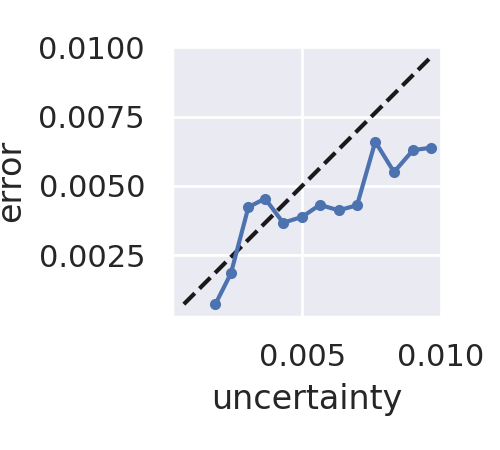

0.07915061432868242


In [12]:
n_bins = 15
uce_uncal, _, _, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins)
_, err_uncal, sigma_uncal, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins, range=[0, 0.01])
plot_uncert(err_uncal.cpu(), sigma_uncal.cpu())
print(uce_uncal.item()*100)

# Rejection of unreliable predictions

In [13]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [14]:
e_s_list = []
u_s_list = []
t_s_list = []
num_rejected_s = []
uncert_s = uncert_test**2
err = (err_test**2)

for thresh in np.linspace(uncert_s.max().item(), uncert_s.min().item(), 100)[:-1]:
    e = err[torch.where(uncert_s < thresh)]
    u = uncert_s[torch.where(uncert_s < thresh)]

    t_s_list.append(thresh)
    e_s_list.append(e.mean().item())
    u_s_list.append(u.mean().item())
    num_rejected_s.append((err_test.shape[0]-e.shape[0])/err_test.shape[0])

t_s_list = np.array(t_s_list)
e_s_list = np.array(e_s_list)
u_s_list = np.array(u_s_list)
num_rejected_s = np.array(num_rejected_s)

<IPython.core.display.Javascript object>


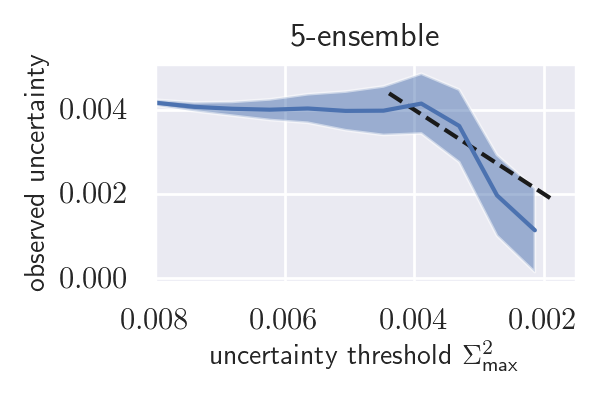

In [15]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))

ax.plot([0.0019, e_s_list.max()], [0.0019, e_s_list.max()], 'k--')
ax.plot(t_s_list, e_s_list)
ax.fill_between(t_s_list, e_s_list-num_rejected_s/1000, e_s_list+num_rejected_s/1000, alpha=0.5)
ax.set_xlim(
    #ax[0].get_xlim()[1],
    0.008,
    0.0015)
ax.set_xlabel(r'uncertainty threshold $ \Sigma^2_{\mathsf{max}} $', fontsize=10)
ax.set_ylabel(r'observed uncertainty', fontsize=10)
ax.set_title(r'5-ensemble')

fig.tight_layout()
fig.show()
fig.savefig(f"rejection_ensemble_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)

# OOD detection

In [56]:
y_ps_ood = []
mus_ood = []
vars_ood = []
logvars_ood = []
targets_ood = []

with torch.no_grad():
    for s in [0.0, 0.1, 0.2]:
        y_ps_test = []
        vars_test = []
        logvars_test = []
        targets_test = []
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            data = data + torch.randn_like(data)*s + s

            y_ps = []
            logvars = []
            for net in ensembles:
                y_p, logvar, _ = net(data, dropout=False, mc_dropout=False)
                y_ps.append(y_p)
                logvars.append(logvar)

            y_ps = torch.stack(y_ps)
            var = y_ps.var(dim=0)
            logvars = torch.stack(logvars).mean(dim=0)

            y_ps_test.append(y_ps.detach())
            vars_test.append(var.detach())
            logvars_test.append(logvar.detach())
            targets_test.append(target.detach())
        
        y_p_test = torch.cat(y_ps_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = y_p_test.mean(dim=1)
        var_test = torch.cat(vars_test, dim=0)
        logvar_test = torch.cat(logvars_test, dim=0)
        target_test = torch.cat(targets_test, dim=0)
    
        y_ps_ood.append(y_p_test)
        mus_ood.append(mu_test)
        vars_ood.append(var_test)
        logvars_ood.append(logvar_test)
        targets_ood.append(target_test)

100%|██████████| 250/250 [03:02<00:00,  1.37it/s]


In [66]:
errs_ood = []
uncerts_ood = []

for i in range(len(y_ps_ood)):
    err_test = (targets_ood[i]-mus_ood[i]).pow(2).mean(dim=1, keepdim=True).sqrt()
    errvar_test = (y_ps_ood[i]-targets_ood[i].unsqueeze(1).repeat(1,num_ensembles,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

    uncert_aleatoric_test = logvars_ood[i].exp().mean(dim=1, keepdim=True)
    uncert_epistemic_test = vars_ood[i].mean(dim=1, keepdim=True)

    if uncertainty == 'aleatoric':
        uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
    elif uncertainty == 'epistemic':
        uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
    else:
        uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)

    uncerts_ood.append(uncert_test.detach().cpu().numpy())
    errs_ood.append(errvar_test.detach().cpu().numpy())

In [67]:
uncerts_ood_np = np.array(uncerts_ood).reshape(3,-1)
errs_ood_np = np.array(errs_ood).reshape(3,-1)

<IPython.core.display.Javascript object>


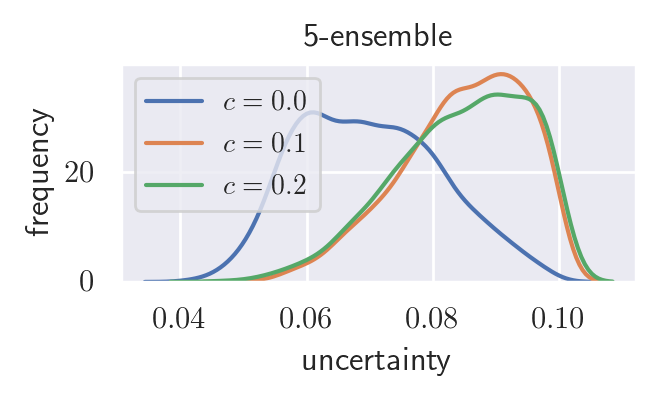

In [68]:
fig, ax = plt.subplots(figsize=(3.3, 2.0))

labels = [r'$c=0.0$', r'$c=0.1$', r'$c=0.2$']

for i in range(3):
    data = uncerts_ood_np[i][np.where(uncerts_ood_np[i] < 0.1)]
    sns.distplot(data, hist_kws={'stacked': True}, kde=True, hist=False, norm_hist=True, label=labels[i], ax=ax)

ax.legend(prop={'size': 10})
#ax.set_ylim([-30, 510])
#ax.set_xticks([0, 0.005, 0.01])
ax.set_xlabel(r'uncertainty')
ax.set_ylabel(f'frequency')
ax.set_title(f'5-ensemble')
fig.tight_layout()
fig.show()
fig.savefig(f"ood_boneage_ensemble_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)